## Group Convolutional Neural Networks

This notebook is made by [**Anas Aldadi**](https://github.com/AnasKAN)

Before I implement the paper [Group Equivariant CNNs](https://arxiv.org/abs/1602.07576) by Taco and Max. I must first explain Equivariance and Invariance:

* Equivariance

    A desirable characteristic when approximating anything (e.g. a cat image) using neural networks is having it be equivariant to the input. No matter how the desired object moves inside the input you want the activation to be where the object is

* Invariance

    A function is said to be invariant when the same input goes to the function no matter what transformation happened to it, the function output will be the same.

An image to demonstrate the difference with the mathematical definition of both equivariance and invariance:

<img src="https://drive.google.com/uc?id=1jMfn6yYvQW4YT9ERKN5tKuOilLawxakz" width="800"/>

[source of the image](https://www.youtube.com/watch?v=03MbWVlbefM&t=1393s)

Important to note that both equivariance and invariance are always defined with respect to a set of transformation class. In classical CNNs it is translations in 2D space.

Classical CNNs are translation equivariant, meaning that when an object in the input is translated, the feature maps translate correspondingly. or stay constant for invariance. Which are the pooling layers represent invariant component in the network.

---

**FYI:**

* **Classical CNNs** are only equivariant to translations, but not rotations or reflections.

* **MLPs** are not equivariant to any spatial transformation; the input structure matters.

* **Transformers** without positional encoding are permutation invariance.

---

<img src="https://drive.google.com/uc?id=1mc0-6IulSlWYbfgulXWn-AN0AaNTG1S0" width="800"/>

As you can see, the convolution formula applies a kernel $k$ to the signal $f$ (which in our case its an image), which can be expressed as 2 summations on the right hand side of the equation, we can see that the kernel $k_i$ shifted across the input by $(x-y)$ and this is what gives the classical CNNs translation equivariance!

The key idea behind Group Equivariant CNNs (G-CNNs) is to extend this equivariance from just translations to larger transformation groups (e.g., rotations, reflections). By doing so, the network respects the symmetries of the data and generalizes better with fewer parameters.
But this typically works with discrete groups like the cyclic group $C_4$ $=$ {$0°,45°,90°,180°$}.

I highly suggest to checkout this [video on equivariant neural nets](https://www.youtube.com/watch?v=2bP_KuBrXSc) which will help you alot to grasp the basics of group theory and symmetries in math.

I will build the simplest G-CNN which only consider the rotations of cyclic group $C_4$.

### Reqs

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Helper

In [53]:
def show_feature_maps(model, x, model_name="G-CNN"):
    model.eval()
    with torch.no_grad():
        feats = model(x, return_features=True)

    if model_name == "G-CNN":
        # feats shape: [B, 4, 8, H, W]
        feats = feats[0]  # first image in batch → [4, 8, H, W]
        group_rot_names = ["0°", "90°", "180°", "270°"]
        for g in range(4):
            fig, axs = plt.subplots(1, 8, figsize=(16, 2))
            for i in range(8):
                axs[i].imshow(feats[g, i].cpu(), cmap='viridis')
                axs[i].axis('off')
                axs[i].set_title(f'F{i}')
            fig.suptitle(f'G-CNN - Group Element: {group_rot_names[g]}', fontsize=14)
            plt.show()

    elif model_name == "CNN":
        # feats shape: [B, 8, H, W]
        feats = feats[0]  # [8, H, W]
        fig, axs = plt.subplots(1, 8, figsize=(16, 2))
        for i in range(8):
            axs[i].imshow(feats[i].cpu(), cmap='viridis')
            axs[i].axis('off')
            axs[i].set_title(f'F{i}')
        fig.suptitle('Standard CNN - Feature Maps', fontsize=14)
        plt.show()

In [54]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [55]:
def get_all_preds(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

### Archeticture

#### Classical CNN for comparison

In [14]:
class StandardCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * 28 * 28, 10)
        )

    def forward(self, x, return_features=False):
        feat = self.conv(x)
        if return_features:
            return feat  # shape [B, 8, H, W]
        return self.classifier(feat)

#### G-CNN

In [15]:
def rotate_filter_90s(w, k):
    """
    Rotate kernel tensor w by 90*k degrees counter-clockwise.
    w shape: [C_out, C_in, H, W]
    k: number of 90° rotations (0, 1, 2, 3)
    """
    return torch.rot90(w, k=k, dims=[-2, -1])

class GCNN_C4_Layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Learnable base kernel
        self.weight = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        )
        self.bias = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        # x shape: [B, C_in, H, W]
        outputs = []
        for k in range(4):  # 0°, 90°, 180°, 270°
            w_rot = rotate_filter_90s(self.weight, k)
            out = F.conv2d(x, w_rot, bias=self.bias, padding=self.kernel_size // 2)
            outputs.append(out)
        return torch.stack(outputs, dim=1)  # shape: [B, 4, C_out, H, W]

class GroupPool(nn.Module):
    def forward(self, x):
        # x: [B, G, C, H, W]
        return x.mean(dim=1)  # shape: [B, C, H, W]

class SimpleGCNN_C4(nn.Module):
    def __init__(self):
        super().__init__()
        self.gconv = GCNN_C4_Layer(1, 8, kernel_size=3)
        self.pool = GroupPool()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * 28 * 28, 10)
        )

    def forward(self, x, return_features=False):
        x = self.gconv(x)    # [B, 4, 8, H, W]
        if return_features:
            return x
        x = self.pool(x)    # [B, 8, H, W]
        return self.classifier(x)

In [2]:
x = torch.randn(2, 1, 28, 28)
model = SimpleGCNN_C4()
out = model(x)
print(out.shape)

torch.Size([2, 10])


### Data

In [3]:
# Random C4 rotation: 0°, 90°, 180°, 270°
def random_c4_rotation(img):
    k = torch.randint(0, 4, ()).item()
    return transforms.functional.rotate(img, angle=90 * k)

# Transforms
train_transform = transforms.Compose([
    transforms.Lambda(random_c4_rotation),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset_rotated = datasets.MNIST(root='./data', train=False, transform=train_transform, download=True)
test_dataset_original = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_rotated = DataLoader(test_dataset_rotated, batch_size=64)
test_loader_original = DataLoader(test_dataset_original, batch_size=64)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]


### Training

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleGCNN_C4().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [17]:
for epoch in range(1, 6):  # 5 epochs
    loss = train(model, train_loader)
    acc_rot = evaluate(model, test_loader_rotated)
    acc_orig = evaluate(model, test_loader_original)
    print(f"Epoch {epoch}: Loss={loss:.4f}, Acc(Rotated)={acc_rot:.4f}, Acc(Original)={acc_orig:.4f}")

Epoch 1: Loss=1.1328, Acc(Rotated)=0.6554, Acc(Original)=0.6595
Epoch 2: Loss=1.0510, Acc(Rotated)=0.6516, Acc(Original)=0.6601
Epoch 3: Loss=1.0372, Acc(Rotated)=0.6580, Acc(Original)=0.6460
Epoch 4: Loss=1.0303, Acc(Rotated)=0.6624, Acc(Original)=0.6670
Epoch 5: Loss=1.0256, Acc(Rotated)=0.6648, Acc(Original)=0.6746


In [18]:
model_cnn = StandardCNN().to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

In [19]:
for epoch in range(1, 6):
    loss = train(model_cnn, train_loader)
    acc_rot = evaluate(model_cnn, test_loader_rotated)
    acc_orig = evaluate(model_cnn, test_loader_original)
    print(f"[Standard CNN] Epoch {epoch}: Loss={loss:.4f}, Acc(Rotated)={acc_rot:.4f}, Acc(Original)={acc_orig:.4f}")

[Standard CNN] Epoch 1: Loss=2.3048, Acc(Rotated)=0.1039, Acc(Original)=0.0769
[Standard CNN] Epoch 2: Loss=2.3050, Acc(Rotated)=0.0996, Acc(Original)=0.0769
[Standard CNN] Epoch 3: Loss=2.3051, Acc(Rotated)=0.0994, Acc(Original)=0.0769
[Standard CNN] Epoch 4: Loss=2.3052, Acc(Rotated)=0.0999, Acc(Original)=0.0769
[Standard CNN] Epoch 5: Loss=2.3055, Acc(Rotated)=0.1022, Acc(Original)=0.0769


### Eval

=== G-CNN Classification Report ===
              precision    recall  f1-score   support

           0     0.7828    0.8755    0.8266       980
           1     0.8508    0.9648    0.9042      1135
           2     0.5348    0.4690    0.4997      1032
           3     0.4735    0.6376    0.5435      1010
           4     0.6657    0.7138    0.6889       982
           5     0.5254    0.3711    0.4350       892
           6     0.5807    0.5710    0.5758       958
           7     0.7231    0.7899    0.7550      1028
           8     0.7108    0.5072    0.5920       974
           9     0.7525    0.6779    0.7132      1009

    accuracy                         0.6650     10000
   macro avg     0.6600    0.6578    0.6534     10000
weighted avg     0.6637    0.6650    0.6589     10000



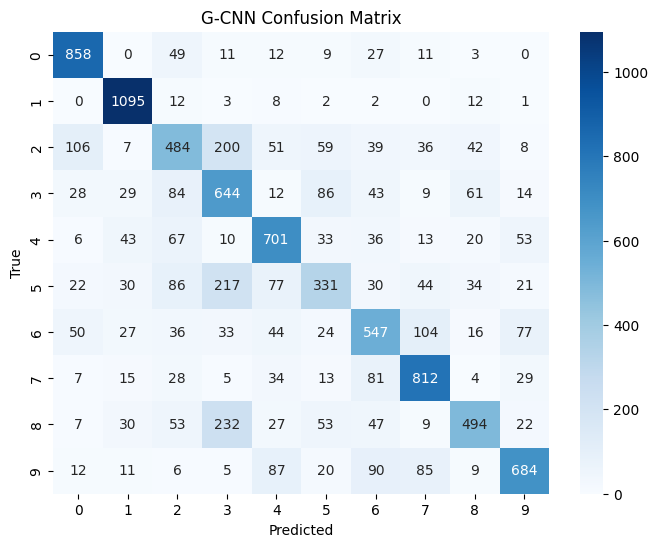

In [57]:
gcnn_preds, gcnn_labels = get_all_preds(model, test_loader_rotated)

print("=== G-CNN Classification Report ===")
print(classification_report(gcnn_labels, gcnn_preds, digits=4))

plot_confusion_matrix(gcnn_labels, gcnn_preds, title="G-CNN Confusion Matrix")

=== Standard CNN Classification Report ===
              precision    recall  f1-score   support

           0     0.0769    0.0031    0.0059       980
           1     0.1039    0.6555    0.1794      1135
           2     1.0000    0.0010    0.0019      1032
           3     0.1218    0.0238    0.0398      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0710    0.0616    0.0660       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0840    0.1477    0.1071      1009

    accuracy                         0.0980     10000
   macro avg     0.1458    0.0893    0.0400     10000
weighted avg     0.1501    0.0980    0.0423     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


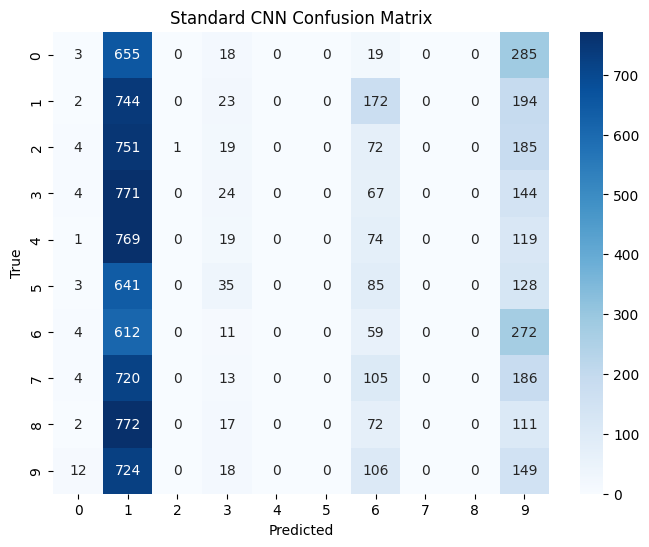

In [58]:
cnn_preds, cnn_labels = get_all_preds(model_cnn, test_loader_rotated)
print("=== Standard CNN Classification Report ===")
print(classification_report(cnn_labels, cnn_preds, digits=4))
plot_confusion_matrix(cnn_labels, cnn_preds, title="Standard CNN Confusion Matrix")